In [ ]:
# !pip install torchsummary

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import PIL
import cv2
import skimage
import numpy as np
from sklearn.model_selection import train_test_split

from torchsummary import summary
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as vision_models

d:\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
home = "./input"
os.listdir("./input/ab/ab")

['ab1.npy', 'ab2.npy', 'ab3.npy']

In [3]:
def load_data(home, channels_first=True, train_percent=0.8):
    ab1 = np.load(os.path.join(home,"ab/ab", "ab1.npy"))
    ab2 = np.load(os.path.join(home, "ab/ab", "ab2.npy"))
    ab3 = np.load(os.path.join(home,"ab/ab", "ab3.npy"))
    ab = np.concatenate([ab1, ab2, ab3], axis=0)
#     ab = np.transpose(ab, [0, 3, 1, 2])
    l = np.load(os.path.join(home,"l/gray_scale.npy"))
    
    
    return train_test_split(ab,l, train_size=train_percent)
    

In [4]:
ab_train, ab_test, l_train, l_test = load_data(home, channels_first=True)
ab_train.shape, l_train.shape, ab_test.shape, l_test.shape

((20000, 224, 224, 2),
 (20000, 224, 224),
 (5000, 224, 224, 2),
 (5000, 224, 224))

## Utility Functions

In [5]:
def plot_channels(img_batch, figsize=(8,3), cmap=None):
    if len(img_batch.shape)==3:
        img_batch = np.expand_dims(img_batch, axis=0)
    for img in img_batch:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1,3,1)
        plt.imshow(img[:,:,0].T, cmap=cmap)
        plt.title(f"ab-0")
        
        plt.subplot(1,3,2)
        plt.imshow(img[:,:,1].T, cmap=cmap)
        plt.title(f"ab-1")
        
        plt.subplot(1,3,3)
        plt.imshow(img[:,:,2].T, cmap=cmap)
        plt.title(f"l")
        
        plt.show()

def plot_image(img_batch, figsize=(8,3), cmap=None, title=None):
    if len(img_batch.shape)==3:
        img_batch = np.expand_dims(img_batch, axis=0)
    N = len(img_batch)
    fig = plt.figure(figsize=figsize)
    for i in range(N):
        img = img_batch[i]
#         img = np.transpose(img, [1,0,2])
        plt.subplot(1,N,i+1)
        plt.imshow(img, cmap=cmap)
    if title is not None:
        plt.title(f"{title}")
    plt.show()
        
def to_lab(l, ab, channels_first=True):
    if channels_first:
        if len(l.shape)==3:
            l = np.expand_dims(l, axis=1)
        lab = np.concatenate([l, ab], axis=1)
    else:
        if len(l.shape)==3:
            l = np.expand_dims(l, axis=3)
        lab = np.concatenate([l, ab], axis=3)
    return lab

def lab2rgb(lab):
    if len(lab.shape)==4:
        arr = []
        for img in lab:
            img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
            arr.append(img)
        arr = np.array(arr)
    else:
        arr = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return arr

def rgb2lab(rgb):
    if len(rgb.shape)==4:
        arr = []
        for img in rgb:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            arr.append(img)
        arr = np.array(arr)
    else:
        arr = cv2.cvtColor(rgb, cv2.COLOR_LAB2RGB)
    return arr

def to_channel_first(arr):
    if len(arr.shape)==4:
        arr = np.transpose(arr, [0,3,2,1])
    else:
        arr = np.transpose(arr, [2,1,0])
    return arr

def to_channel_last(arr):
    if len(arr.shape)==4:
        arr = np.transpose(arr, [0,3,2,1])
    else:
        arr = np.transpose(arr, [2,1,0])
    return arr

## Dataset Implementation

In [6]:
class DatasetImg(Dataset):
    def __init__(self, l, ab, input_transforms=[], output_transforms=[]):
        self.l = l
        self.ab = ab
        self.input_transforms = input_transforms
        self.output_transforms = output_transforms
    
    def __len__(self):
        return len(self.l)
    
    def __getitem__(self, idx):
        x = self.l[idx]
        y = self.ab[idx]
        
        if self.input_transforms is not None:
            for fn in self.input_transforms:
                x = fn(x)
        
        if self.output_transforms is not None:
            for fn in self.output_transforms:
                y = fn(y)
        return x,y

## Transform functions

In [7]:
def transform_expand_dim(axis):
    def fn(arr):
        arr = np.expand_dims(arr, axis=axis)
        return arr
    return fn

def transform_multiply(mul):
    def fn(arr):
        arr = arr * mul
        return arr
    return fn

def transform_divide(div):
    def fn(arr):
        arr = arr / div
        return arr
    return fn

def model_parameters_count(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

## Unet Model

In [8]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

def build_fastai_model(in_channels=1, out_channels=2, image_shape=(224, 224)):
    model_body = create_body(resnet18(), n_in=in_channels, cut=-2)
    model = DynamicUnet(encoder=model_body, n_out=out_channels, img_size=image_shape)
    return model

# m = build_fastai_model()
# print(summary(m, (1,224,224)))

# list(dict([(k,v) for k,v in list(m.named_parameters())]).keys())
# a = torch.randn(2, 1, 224,224)
# m(a).shape
# m

In [9]:
# class BlockConv(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias):
#         self.sequential = nn.Sequential(
#             nn.Conv2d(in_channels,out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(),
#             nn.Dropout2d()
#         )
    
#     def forward(self, x):
#         x = self.sequential(x)
#         return x

# class BlockConvTranspose(nn.Module):
#     def __init__(self, in_channels, out_channels)

In [10]:
# class ModelConvUnet(nn.Module):
#     def __init__(self, in_shape=[224, 224], in_channels=1, out_channels=2):
#         super(ModelConvUnet, self).__init__()
#         self.sequential = nn.Sequential(
#             nn.Conv2d(in_channels,16, kernel_size=3, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.Dropout2d(),
            
#             nn.Conv2d(16,32, kernel_size=3, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Dropout2d(),
            
#             nn.Conv2d(32,64, kernel_size=3, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Dropout2d(),
            
#             nn.Conv2d(64,128, kernel_size=3, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.Dropout2d(),
            
#             nn.Conv2d(128,256, kernel_size=3, stride=2, padding=2, bias=False),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.Dropout2d(),
            
# #             nn.Conv2d(256,512, kernel_size=3, stride=2, padding=1, bias=False),
# #             nn.BatchNorm2d(512),
# #             nn.ReLU(),
# #             nn.Dropout2d(),
            
#             nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=0),
#             nn.Dropout2d(),
#             nn.ReLU(),
#             nn.BatchNorm2d(128),
            
#             nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
#             nn.Dropout2d(),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
            
#             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0),
#             nn.Dropout2d(),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
            
#             nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=0),
#             nn.Dropout2d(),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
            
#             nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.Dropout2d(),
#             nn.ReLU(),
#             nn.BatchNorm2d(8),
            
#             nn.Conv2d(8,2, kernel_size=3, stride=1,padding=0)
#         )
    
#     def forward(self, x):
#         x = self.sequential(x)
#         return x

# mdl = ModelConvUnet()
# a = torch.randn(2, 1, 224,224)
# b = mdl(a)
# print("Model parameters:", model_parameters_count(mdl))
# a.shape, b.shape

In [11]:
# resnet18 = vision_models.resnet18(pretrained=True)

In [12]:
# dict([(k,v) for k,v in resnet18.named_parameters()]).keys()

In [13]:
# list(resnet18.children())[0](torch.randn(2,1,224,224))

## train, validation, test

In [14]:
def train(model, loss_fn, optimizer, dataloader_train, device):
    model = model.to(device)
    N = len(dataloader_train.dataset)
    n_batch = int(N / dataloader_train.batch_size)
    model.train()
    losses = []
    for batch, (x,y) in enumerate(dataloader_train):
        x = x.to(device).float()
        y = y.to(device).float()
        # print("test() x.shape", x.shape)
        pred = model(x)
        loss = loss_fn(pred, y)
        losses.append(loss.item())
        # Backpropagation.
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
        
        sys.stdout.write(f"\rTrain: {batch+1}/{n_batch} loss:{loss}")
        sys.stdout.flush()
        # break
    avg_loss = np.mean(losses)
    return avg_loss

def test(model, loss_fn, dataloader_test, device):
    model = model.to(device)
    N = len(dataloader_test.dataset)
    n_batch = int(N / dataloader_test.batch_size)
    losses = []
    model.eval()
    with torch.no_grad():
        for batch, (x,y) in enumerate(dataloader_test):
            x,y = x.to(device).float(), y.to(device).float()
            
            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            
            sys.stdout.write(f"\rTest: {batch+1}/{n_batch} loss_test:{loss}")
            sys.stdout.flush()
            # break
    avg_loss = np.mean(losses)
    return avg_loss

def predict(model, dataloader_test, device, num_batches=4):
    model = model.to(device)
    N = len(dataloader_test.dataset)
    n_batch = int(N / dataloader_test.batch_size)
    model.eval()
    y_actual = []
    y_pred = []
    inputs = []
    ys = []
    with torch.no_grad():
        for batch, (x,y) in enumerate(dataloader_test):
#             ys.append(y)
#             inputs.append(x)
            x,y = x.to(device).float(), y.to(device).float()
            pred = model(x)
            if device == "cuda":
                y_actual.append(np.squeeze(y.detach().cpu().numpy()))
                y_pred.append(np.squeeze(pred.detach().cpu().numpy()))
            else:
                y_actual.append(np.squeeze(y.detach().numpy()))
                y_pred.append(np.squeeze(pred.detach().numpy()))
            inputs.append(x.detach().cpu().numpy())
            
            sys.stdout.write(f"\rPred: {batch+1}/{n_batch}")
            sys.stdout.flush()
            if batch+1 == num_batches:
                break
#     y_actual = [temp if len(temp.shape)>0 else np.array([temp])  for temp in y_actual]
#     y_pred = [temp if len(temp.shape)>0 else np.array([temp])  for temp in y_pred]
    y_actual = np.concatenate(y_actual)
    y_pred = np.concatenate(y_pred)
    inputs = np.concatenate(inputs)
#     ys = np.concatenate(ys)
    return inputs, y_actual, y_pred #, ys
        

### Define parameters

In [15]:
input_shape = [224, 224]
batch_size = 1
num_examples = -1
device=  "cuda" if torch.cuda.is_available() else "cpu"
epochs = 10
plot_freq = 5

model = build_fastai_model()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [16]:
torch.cuda.is_available()


True

Output exceeds the size limit. Open the full output data in a text editor
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[16], line 8
      5 epochs = 100
      6 plot_freq = 5
----> 8 model = build_fastai_model()
     10 optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
     11 loss_fn = nn.MSELoss()

Cell In[9], line 6, in build_fastai_model(in_channels, out_channels, image_shape)
      5 def build_fastai_model(in_channels=1, out_channels=2, image_shape=(224, 224)):
----> 6     model_body = create_body(resnet18, n_in=in_channels, cut=-2)
      7     model = DynamicUnet(encoder=model_body, n_out=out_channels, img_size=image_shape)
      8     return model

File c:\Users\KUAAA\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\vision\learner.py:78, in create_body(model, n_in, pretrained, cut)
     76 def create_body(model, n_in=3, pretrained=True, cut=None):
     77     "Cut off the body of a typically pretrained `arch` as determined by `cut`"
---> 78     _update_first_layer(model, n_in, pretrained)
     79     if cut is None:
     80         ll = list(enumerate(model.children()))

File c:\Users\KUAAA\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\vision\learner.py:57, in _update_first_layer(model, n_in, pretrained)
     55 "Change first layer based on number of input channels"
     56 if n_in == 3: return
...
---> 34 for n in next(m.named_parameters())[0].split('.')[:-1]:
     35     p,c=c,getattr(c,n)
     36 return c,p,n

AttributeError: 'function' object has no attribute 'named_parameters'

----> 6     model_body = create_body(resnet18, n_in=in_channels, cut=-2)

----> 6     model_body = create_body(resnet18(), n_in=in_channels, cut=-2)

In [17]:
input_transforms = [transform_expand_dim(axis=2),
                    to_channel_first,
                   transform_divide(255.0)
                   ]
output_transforms = [
                    to_channel_first,
                   transform_divide(255.0)
                   ]

ds_train = DatasetImg(l_train[:num_examples], ab_train[:num_examples], input_transforms=input_transforms, output_transforms=output_transforms)
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)

ds_test = DatasetImg(l_test[:num_examples], ab_test[:num_examples], input_transforms=input_transforms, output_transforms=output_transforms)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True)


Epoch 1/10
Train: 19999/19999 loss:0.00084748177323490384
Test: 4999/4999 loss_test:0.00294403336010873333
Epoch 2/10
Train: 19999/19999 loss:0.00162415264640003445
Test: 4999/4999 loss_test:0.00036576364072971046
Epoch 3/10
Train: 19999/19999 loss:0.00095342478016391474
Test: 4999/4999 loss_test:0.00082325196126475938
Epoch 4/10
Train: 19999/19999 loss:0.00106133427470922474
Test: 4999/4999 loss_test:0.00694768130779266434
Epoch 5/10
Train: 19999/19999 loss:0.00414027832448482547
Pred: 1/1249999 loss_test:0.00592376012355089253

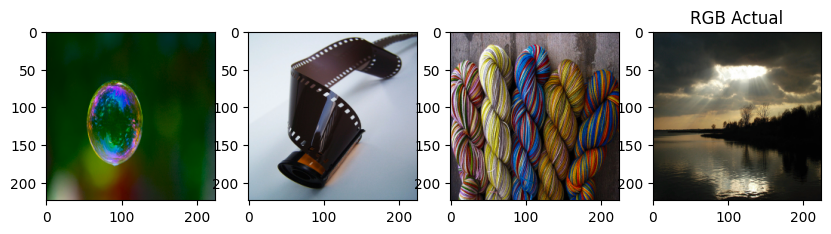

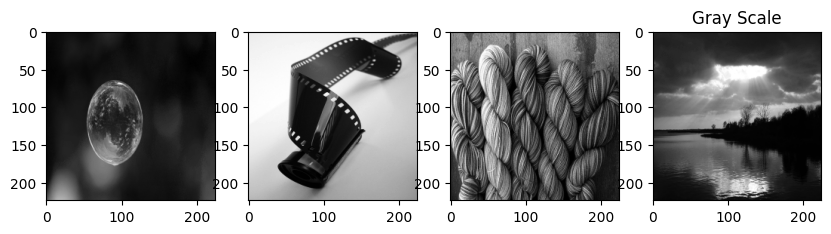

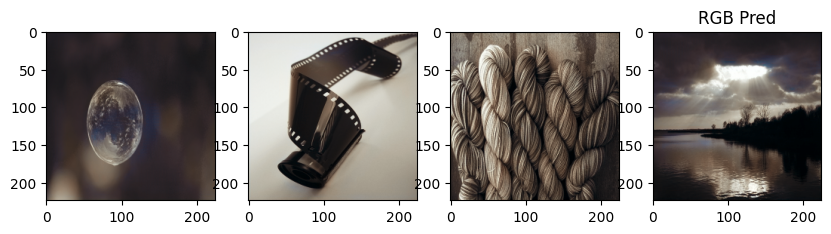

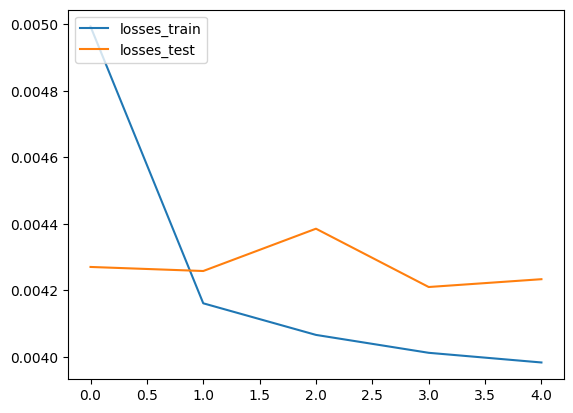


Epoch 6/10
Train: 19999/19999 loss:0.00115257070865482113
Test: 4999/4999 loss_test:0.00909080542623996735
Epoch 7/10
Train: 19999/19999 loss:0.00354504794813692573
Test: 4999/4999 loss_test:0.00213092705234885287
Epoch 8/10
Train: 19999/19999 loss:0.01204936951398849596
Test: 4999/4999 loss_test:0.00748952152207493854
Epoch 9/10
Train: 19999/19999 loss:0.00502918520942330493
Test: 4999/4999 loss_test:0.00140938675031065944
Epoch 10/10
Train: 19999/19999 loss:0.01204145513474941374
Pred: 1/1249999 loss_test:0.00562125537544488926

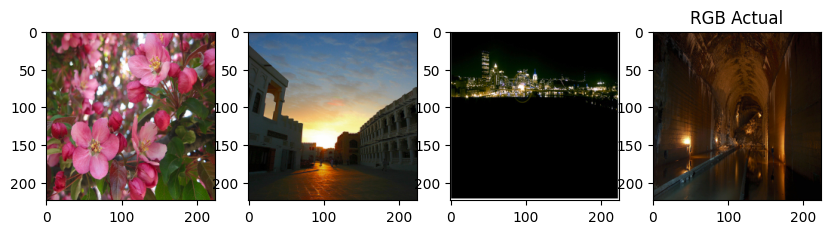

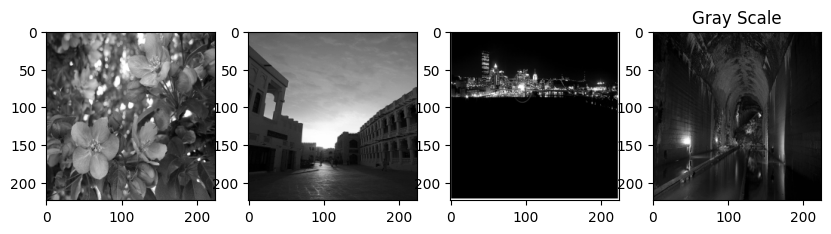

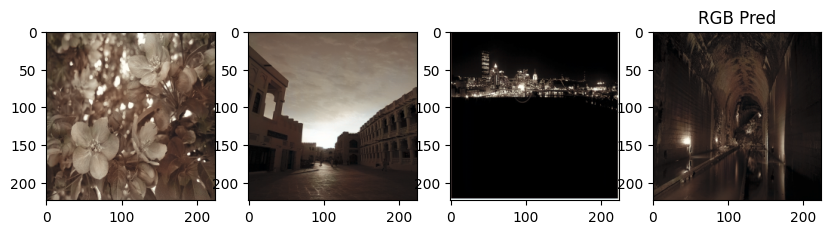

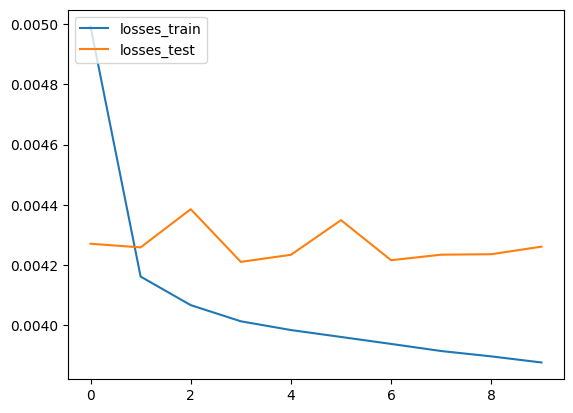

In [18]:
losses_train = []
losses_test = []
plot_freq = 1
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    loss_train = train(model, loss_fn, optimizer, dl_train, device)
    losses_train.append(loss_train)
    print()
    loss_test = test(model, loss_fn, dl_test, device)
    losses_test.append(loss_test)
    
    if (epoch+1)%plot_freq == 0:
        ds_pred = DatasetImg(l_test[:num_examples], ab_test[:num_examples], input_transforms=input_transforms, output_transforms=output_transforms)
        dl_pred = DataLoader(ds_test, batch_size=4, shuffle=True)
        x_pred, y_pred, y_hat_pred = predict(model, dl_pred, device, num_batches=1)

        x_pred = transform_multiply(255.0)(x_pred)
        y_pred = transform_multiply(255.0)(y_pred)
        y_hat_pred = transform_multiply(255.0)(y_hat_pred)
    #     ys = transform_multiply(255.0)(ys)

        x_pred = to_channel_last(x_pred)
        y_pred = to_channel_last(y_pred)
        y_hat_pred = to_channel_last(y_hat_pred)
    #     ys = to_channel_last(ys)

        lab_pred = to_lab(x_pred, y_pred, channels_first=False)
        lab_hat_pred = to_lab(x_pred, y_hat_pred, channels_first=False)

        rgb_pred = lab2rgb(lab_pred.astype("uint8"))
        rgb_hat_pred = lab2rgb(lab_hat_pred.astype("uint8"))

        plot_image(rgb_pred, figsize=(10,10), title="RGB Actual")
        plot_image(x_pred, figsize=(10, 10), cmap="gray", title="Gray Scale")
        plot_image(rgb_hat_pred, figsize=(10,10), title="RGB Pred")
        
        plt.plot(losses_train, label="losses_train")
        plt.plot(losses_test, label="losses_test")
        plt.legend(loc="upper left")
        plt.show()

## Summary
In this notebook we tried illustrate a basic implementation of Image Colorization. From visual inspections we could see that moderate level colorized images could be obtained.


Further Steps: As further steps following points could be experimented.


In this notebook L and AB channels of images are normalized by dividing by 255.0. Following alternate approaches could be followed:



Scale all channels i.e. L,A,B in range -1 to +1.
Scale L in the range of [0,1] and AB in the range of [-1, +1]
Mean Squared Error is used as loss function. As an alternative other loss functions like L1, SmoothL1 could be experimented with.



Resnet18 based UNET model is used. As an alternative other Encoder-Decoder based models could be used. GAN models could also be tried.